In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
# from google.colab import drive
# drive.mount('/content/drive')

warnings.filterwarnings('ignore')

# filepath = '/content/drive/MyDrive/booksummaries/booksummaries.txt'
filepath = 'booksummaries/booksummaries.txt'

In [16]:
df = pd.read_csv(filepath,delimiter='\t')
df.columns = ['WikipediaID', 'Freebase ID', 'Book title', 'Book author', 'Publication date', 'Genres', 'Plot summary']

# duplicate = df[df.duplicated()]
# print("duplicated titles:", duplicate.shape[0])

df.drop(['WikipediaID', 'Freebase ID', 'Book author', 'Publication date'], axis = 1, inplace = True)
# display(df)

In [17]:

df = df[df['Genres'].notna()]
df['Book title'] = df['Book title'].astype(str)
df['Genres'] = df['Genres'].astype(str)
df['Plot summary'] = df['Plot summary'].astype(str)

df = df[~df['Genres'].str.contains('iction') | ~df['Genres'].str.contains('ovel')]
# df = df[~df['Genres'].str.contains('iction') | ~df['Genres'].str.contains('antasy')]
df = df[~df['Genres'].str.contains('orror') | ~df['Genres'].str.contains('hildren')]

df.loc[df['Genres'].str.contains('hildren', na = False), 'Genres'] = 'Children'
df.loc[df['Genres'].str.contains('antasy', na = False), 'Genres'] = 'Fantasy'
# df.loc[df['Genres'].str.contains('iography', na = False), 'Genres'] = 'Biography'
# df.loc[df['Genres'].str.contains('orror', na = False), 'Genres'] = 'Horror'
df.loc[df['Genres'].str.contains('ovel', na = False), 'Genres'] = 'Novel'
# df.loc[df['Genres'].str.contains('ystery', na = False), 'Genres'] = 'Mystery'
df.loc[df['Genres'].str.contains('Science Fiction', na = False), 'Genres'] = 'Science Fiction'
# df.loc[df['Genres'].str.contains('iction', na = False), 'Genres'] = 'Fiction'

df = df[~df['Genres'].str.contains('{')]

df.reset_index(drop=True,inplace = True)


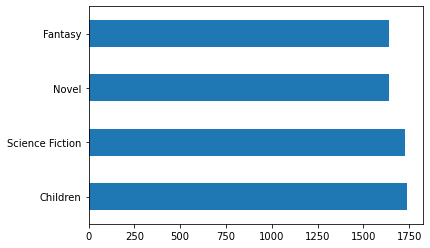

Children           1740
Science Fiction    1729
Novel              1640
Fantasy            1639
Name: Genres, dtype: int64


In [18]:
values = df['Genres'].value_counts()

values.plot(kind='barh')
plt.show()
print(values)

# display(df)

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english').fit(df['Plot summary'])
bag_of_words = vectorizer.transform(df['Plot summary'])

sum_words = bag_of_words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

# display(words_freq)

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, Y_train, Y_test = train_test_split(bag_of_words, df['Genres'], test_size=0.3, stratify=df['Genres'])

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, Y_train)
print(nb_classifier.score(X_test, Y_test))

svm_classifier = make_pipeline(StandardScaler(with_mean=False), SVC(gamma='auto', kernel='linear'))
svm_classifier.fit(X_train, Y_train)
print(svm_classifier.score(X_test, Y_test))

0.7639506172839506
0.5664197530864198


In [21]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
word_count_tfidf = tfidf_transformer.fit_transform(bag_of_words)
X_train, X_test, Y_train, Y_test = train_test_split(word_count_tfidf, df['Genres'], test_size=0.3, stratify=df['Genres'])

nb_classifier_tf = MultinomialNB()
nb_classifier_tf.fit(X_train, Y_train)
print(nb_classifier_tf.score(X_test, Y_test))

svm_classifier_tf = make_pipeline(StandardScaler(with_mean=False), SVC(gamma='auto', kernel='linear'))
svm_classifier_tf.fit(X_train, Y_train)
print(svm_classifier_tf.score(X_test, Y_test))

0.7333333333333333
0.6869135802469136


In [22]:
from sklearn.feature_selection import SelectKBest, chi2

chi2_selector = SelectKBest(chi2, k=2)
chi2_selector.fit(X_train, Y_train)

chi2_scores = pd.DataFrame(list(zip(df['Genres'], chi2_selector.scores_, chi2_selector.pvalues_)), columns=['Genres', 'score', 'pval'])
# display(chi2_scores)
display(chi2_scores.groupby('Genres').mean())

,score,pval
Genres,,
Children,0.489984,0.919969
Fantasy,0.483004,0.917925
Novel,0.459939,0.921115
Science Fiction,0.468651,0.923029


In [23]:
scores = cross_val_score(nb_classifier_tf, bag_of_words, df['Genres'], cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(nb_classifier_tf, X_train, Y_train, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(svm_classifier_tf, bag_of_words, df['Genres'], cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores = cross_val_score(svm_classifier_tf, X_train, Y_train, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.71 accuracy with a standard deviation of 0.02
0.73 accuracy with a standard deviation of 0.01
0.52 accuracy with a standard deviation of 0.03
0.69 accuracy with a standard deviation of 0.01


In [24]:
from sklearn.model_selection import GridSearchCV

parameters = {'C':[0.1, 1, 10, 100], 'gamma':[0.1, 1, 10, 100]}
svc = SVC(kernel='linear')
grid = GridSearchCV(svc, parameters, verbose=3)
grid.fit(X_train, Y_train)
print(grid.best_estimator_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ...............................C=0.1, gamma=0.1; total time=  21.1s
[CV 2/5] END ...............................C=0.1, gamma=0.1; total time=  21.5s
[CV 3/5] END ...............................C=0.1, gamma=0.1; total time=  21.3s
[CV 4/5] END ...............................C=0.1, gamma=0.1; total time=  21.3s
[CV 5/5] END ...............................C=0.1, gamma=0.1; total time=  21.3s
[CV 1/5] END .................................C=0.1, gamma=1; total time=  21.2s
[CV 2/5] END .................................C=0.1, gamma=1; total time=  21.7s
[CV 3/5] END .................................C=0.1, gamma=1; total time=  21.4s
[CV 4/5] END .................................C=0.1, gamma=1; total time=  22.1s
[CV 5/5] END .................................C=0.1, gamma=1; total time=  21.3s
[CV 1/5] END ................................C=0.1, gamma=10; total time=  20.9s
[CV 2/5] END ................................C=0